# Detecting Political Bias with an RNN

## Setup

In [2]:
import pathlib
import os
import math, random

import numpy as np
import tensorflow as tf
from tensorflow.keras import utils

from tensorflow.keras import preprocessing

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # Import the stop word list

import re

tf.__version__


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/muhammadrafay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'2.3.0'

Import `matplotlib` and create a helper function to plot graphs:

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])

## Setup input pipeline




In [6]:
cwd = os.getcwd()
dataset_dir = pathlib.Path(cwd).parent.parent/'Data'/'IBC_Dataset'

train_dir = pathlib.Path(cwd).parent.parent/'Data'/'IBC_Dataset'/'Train'
test_dir = pathlib.Path(cwd).parent.parent/'Data'/'IBC_Dataset'/'Test'

print(dataset_dir)

print(train_dir)
print(test_dir)


/Users/muhammadrafay/Desktop/UIUC/Fall2020/CS410_Text_Information_Systems/Final Project/Political_Bias_NLP/Data/IBC_Dataset
/Users/muhammadrafay/Desktop/UIUC/Fall2020/CS410_Text_Information_Systems/Final Project/Political_Bias_NLP/Data/IBC_Dataset/Train
/Users/muhammadrafay/Desktop/UIUC/Fall2020/CS410_Text_Information_Systems/Final Project/Political_Bias_NLP/Data/IBC_Dataset/Test


In [7]:

def title_cleaning( raw_title ):
    # 1. 
    review_text = raw_title
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [8]:

train_split = 0.8


cwd = os.getcwd()

labeled_left_dir = pathlib.Path.joinpath(dataset_dir, "Labeled_Data/Left/Left.txt")
labeled_right_dir = pathlib.Path.joinpath(dataset_dir, "Labeled_Data/Right/Right.txt")

Train_left_dir = pathlib.Path.joinpath(dataset_dir, "Train/Left")
Train_right_dir = pathlib.Path.joinpath(dataset_dir, "Train/Right")

Test_left_dir = pathlib.Path.joinpath(dataset_dir, "Test/Left")
Test_right_dir = pathlib.Path.joinpath(dataset_dir, "Test/Right")

labeled_dirs = [labeled_left_dir, labeled_right_dir]
train_dirs = [Train_left_dir, Train_right_dir]
test_dirs = [Test_left_dir, Test_right_dir]


for dr in range(2):

    f = open(labeled_dirs[dr], "r")
    lines = f.readlines()

    
    arr = np.arange(0,len(lines))
    np.random.shuffle(arr)
    
    nTrain = math.floor(len(lines)*train_split)
    
    
    c = 0  
    for i in range(nTrain):
        c = c + 1                                   
        file_path = pathlib.Path.joinpath(train_dirs[dr], str(c) + '.txt')                                    
        nf = open(file_path, "w")
        nf.write(title_cleaning(lines[arr[i]]))
    
    c = 0
    for i in range(nTrain, len(lines)):
        c = c + 1                                   
        file_path = pathlib.Path.joinpath(test_dirs[dr], str(c) + '.txt')                                    
        nf = open(file_path, "w")
        nf.write(lines[arr[i]])




In [9]:
batch_size = 16
seed = 42


raw_train_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    seed = seed)

raw_test_ds = preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    seed=seed)


Found 2980 files belonging to 2 classes.
Found 746 files belonging to 2 classes.


In [10]:
for text_batch, label_batch in raw_train_ds.take(2):
    for i in range(10):
        print("Question: ", text_batch.numpy()[i][:100], '...')
        print("Label:", label_batch.numpy()[i])

Question:  b'national labor relations board decisions bush appointees made easier employees harass intimidate pro' ...
Label: 0
Question:  b'sounds good surface still far ideal solution n stop fraud starts places responsibility identifying i' ...
Label: 0
Question:  b'past years growing number evangelical churches joined called church growth movement favors contempor' ...
Label: 0
Question:  b'k alternative ready wings makes easier convince workers accept dismantling defined benefit plan clea' ...
Label: 0
Question:  b'hand pro abortion side referred positively prochoice ignoring fact one right kill innocent human' ...
Label: 1
Question:  b'elitist assumption people n change either ignorant problems ignorant solutions' ...
Label: 0
Question:  b'financial institution helps enterprise borrow people savings better equip workers become productive ' ...
Label: 1
Question:  b'ironically values touted weird multiculturalists prevalent nowhere backyards nationalism religiosity' ...
Label: 0
Qu

In [11]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Left
Label 1 corresponds to Right


Initially this returns a dataset of (text, label pairs):

In [15]:
for example, label in raw_train_ds.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'president barack obama also create global energy corps composed scientists engineers work local partners overseas help reduce global greenhouse gas emissions promote low carbon affordable energy solutions developing nations'
 b'u federal reserve treasury department created trillions new money issuing almost limitless stream government debt global market eager supposed security u government guarantee repay interest'
 b'obama administration proposal change rules charitable deductions would also erode incentives charitable giving'
 b'plenty blame go around black latino activists n attack iowa undemocratic attacked iowa new hampshire insufficiently black latino'
 b'u constitution contains supremacy clause override subordinate contradictory law north dakota passing law impose tariffs imports states forbidden document natural laws inherent supremacy clause morally invalidate delegitimize conflicting man made law'
 b'unfortunately many people charge energy policy several decades see

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [16]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [17]:
train_dataset = raw_train_ds
test_dataset =  raw_test_ds
#train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
#test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'new sexual free market meritocratic rather democratic favored beautiful intelligent rich deliberately undercutting institution traditionally provided common man stability social capital two parent family'
 b'trawl online arguments payday lending likely come across something like americans fairness lending prophet ezekiel includes usury list abominable things along rape murder robbery idolatry'
 b'genuinely freed market workers would find significantly easier present work say abusive work environments bargain effectively appealing wages working conditions opportunities direct workplaces']

labels:  [1 1 1]


## Create the text encoder

 The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. 

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [19]:
VOCAB_SIZE = 2300
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [20]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'government', 'would', 'people', 'economic', 'tax',
       'care', 'make', 'health', 'free', 'energy', 'one', 'new', 'social',
       'public', 'even', 'create', 'market', 'economy'], dtype='<U16')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [21]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  13,  816,   10,   18,    1,  109,  192,  634,    1,    1,   48,
           1,    1, 1822,    1, 1026,  384,  239, 1748,   14,  187,  165,
           1,  175,    0,    0,    0,    0,    0,    0,    0],
       [   1,    1,  309,    1, 1110,  225,  407,  712,  545,   34,   57,
           1, 1110,    1,    1, 1205,    1, 1435,    1,  236,  573,  940,
         832,    1,    1,    0,    0,    0,    0,    0,    0],
       [   1, 1842,   18,   38,    3,  633,    1,  636,  621,   54,  278,
        1945,   54,    1,    1,  668,    1,  388,   97,  406,  377,  707,
           1,    0,    0,    0,    0,    0,    0,    0,    0]])

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [22]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'new sexual free market meritocratic rather democratic favored beautiful intelligent rich deliberately undercutting institution traditionally provided common man stability social capital two parent family'
Round-trip:  new sexual free market [UNK] rather democratic favored [UNK] [UNK] rich [UNK] [UNK] institution [UNK] provided common man stability social capital two [UNK] family       

Original:  b'trawl online arguments payday lending likely come across something like americans fairness lending prophet ezekiel includes usury list abominable things along rape murder robbery idolatry'
Round-trip:  [UNK] [UNK] arguments [UNK] lending likely come across something like americans [UNK] lending [UNK] [UNK] includes [UNK] list [UNK] things along rape murder [UNK] [UNK]      

Original:  b'genuinely freed market workers would find significantly easier present work say abusive work environments bargain effectively appealing wages working conditions opportunities direct workplaces'

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [24]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [25]:
# predict on a sample text without padding.

sample_text = ('Republicans lack agreement on Obamacare ahead of Trump speech')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.02273456]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [26]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.02273456]


Compile the Keras model to configure the training process:

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['binary_accuracy'])

## Train the model

In [37]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, #testdataset required
                    validation_steps=10)

Epoch 1/10
187/187 [==============================] - 6s 33ms/step - loss: 0.0985 - binary_accuracy: 0.9748 - val_loss: 3.5521 - val_binary_accuracy: 0.6750
Epoch 2/10
187/187 [==============================] - 5s 25ms/step - loss: 0.0715 - binary_accuracy: 0.9805 - val_loss: 3.9114 - val_binary_accuracy: 0.6375
Epoch 3/10
187/187 [==============================] - 5s 25ms/step - loss: 0.0646 - binary_accuracy: 0.9826 - val_loss: 5.3625 - val_binary_accuracy: 0.6062
Epoch 4/10
187/187 [==============================] - 5s 25ms/step - loss: 0.0626 - binary_accuracy: 0.9832 - val_loss: 3.9472 - val_binary_accuracy: 0.6812
Epoch 5/10
187/187 [==============================] - 5s 27ms/step - loss: 0.0689 - binary_accuracy: 0.9809 - val_loss: 3.8786 - val_binary_accuracy: 0.6375
Epoch 6/10
187/187 [==============================] - 6s 30ms/step - loss: 0.0499 - binary_accuracy: 0.9876 - val_loss: 4.1857 - val_binary_accuracy: 0.6750
Epoch 7/10
187/187 [==============================] - 6s 3

In [38]:
test_loss, test_acc = model.evaluate(test_dataset) # test_dataset required

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

47/47 [==============================] - 1s 19ms/step - loss: 5.4886 - binary_accuracy: 0.5898
Test Loss: 5.488560199737549
Test Accuracy: 0.5898123383522034


In [39]:
yhat_probs = model.predict(raw_test_ds, verbose=0)
predicted_labels = model.predict_classes(raw_test_ds)

y = np.concatenate([y for x, y in raw_test_ds], axis=0)


predicted_labels  = predicted_labels[:,0]

TP = np.count_nonzero(predicted_labels[y == 1] == 1)

FP = np.count_nonzero(predicted_labels[predicted_labels == 1] != y[predicted_labels == 1])

FN = np.count_nonzero(predicted_labels[predicted_labels == 0] != y[predicted_labels == 0])

Acc = np.count_nonzero(predicted_labels == y)/len(y)


Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1 = (2*Precision*Recall)/(Precision + Recall)

print('Accuracy: %f' % Acc)
print('Precision: %f' % Precision)
print('Recall: %f' % Recall)
print('F1 score: %f' % F1)



Accuracy: 0.504021
Precision: 0.453704
Recall: 0.432353
F1 score: 0.442771


(0.0, 2.5655299216508864)

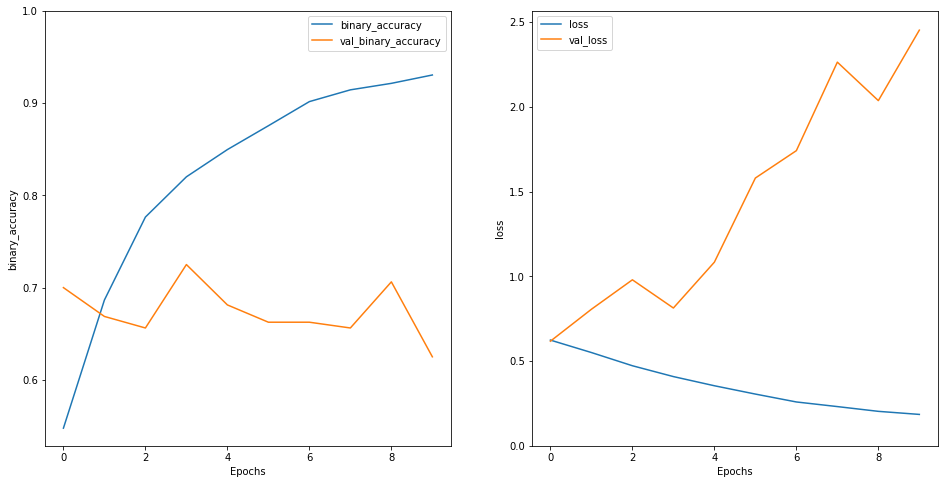

In [33]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'binary_accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

Run a prediction on a neew sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [560]:
# predict on a sample text without padding.

sample_text1 = ('White House, Congress Republicans nearing key tax overhaul decisions')
sample_text2 = ('Democrats Hope Sunday Obamacare Rallies Can Help Them Regain Momentum ')

predictions = model.predict(np.array([sample_text1, sample_text2]))
print(predictions)

[[ 4.434865]
 [-9.360585]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.ipynb)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [561]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [562]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [563]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
194/194 [==============================] - 9s 49ms/step - loss: 0.6921 - accuracy: 0.5205 - val_loss: 0.6903 - val_accuracy: 0.5417
Epoch 2/10
194/194 [==============================] - 5s 26ms/step - loss: 0.6821 - accuracy: 0.5205 - val_loss: 0.6724 - val_accuracy: 0.5312
Epoch 3/10
194/194 [==============================] - 4s 21ms/step - loss: 0.6010 - accuracy: 0.6288 - val_loss: 0.7859 - val_accuracy: 0.6167
Epoch 4/10
194/194 [==============================] - 4s 19ms/step - loss: 0.5087 - accuracy: 0.7176 - val_loss: 0.9723 - val_accuracy: 0.6146
Epoch 5/10
194/194 [==============================] - 4s 20ms/step - loss: 0.4245 - accuracy: 0.7900 - val_loss: 1.2881 - val_accuracy: 0.5562
Epoch 6/10
194/194 [==============================] - 4s 21ms/step - loss: 0.3566 - accuracy: 0.8394 - val_loss: 1.4176 - val_accuracy: 0.5833
Epoch 7/10
194/194 [==============================] - 5s 25ms/step - loss: 0.3097 - accuracy: 0.8759 - val_loss: 1.6140 - val_accuracy: 0.5896

In [564]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

44/44 [==============================] - 0s 7ms/step - loss: 1.8918 - accuracy: 0.6284
Test Loss: 1.8917521238327026
Test Accuracy: 0.6284469962120056


In [565]:
# predict on a sample text without padding.

sample_text1 = ('White House, Congress Republicans nearing key tax overhaul decisions')
sample_text2 = ('Democrats Hope Sunday Obamacare Rallies Can Help Them Regain Momentum ')

predictions = model.predict(np.array([sample_text1, sample_text2]))
print(predictions)

[[ 2.9392362]
 [-8.123318 ]]


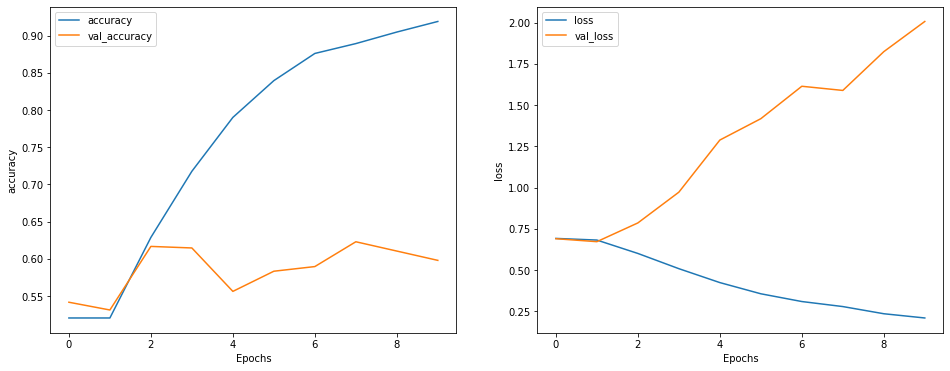

In [566]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')